# Symmetric cipher from scratch: Advanced Encryption Standard (AES) 

This notebook provides an introduction to the most important symmetric cryptographic system, i.e. the [Advanced Encryption Standard (AES)](https://en.wikipedia.org/wiki/Advanced_Encryption_Standard). The AES is a [symmetric cipher](https://en.wikipedia.org/wiki/Symmetric-key_algorithm), i.e. that means the sender and receiver of the message use the same key to encrypt and decrypt their messages. Similar approaches than the AES are also used for hash functions. Understanding AES therefore constitutes a fundamental concept for cryptography - and also for understsanding the concept of hash functions, etc.

In brief, the AES is an algorithm that describes how to convert a message of $128$-bit message $m$ into an encrypted 128-bit message $AES(m,k)$ via a cryptographic key $k$. The cryptographic key is a $128$-bit, a $192$-bit, or a $256$-bit key depending on the AES standard that you would like to use: **AES-128, AES-192, AES-256**. The higher the bit size, the more secure the encryption is.

The AES essentially scrambles the bits of a $128$-bit message over several rounds to produce an output $AES(m,k)$ such that:
1. Nobody could ever reproduce the input $m$ from $AES(m,k)$ **without knowing** the key $k$. 
1. One can very easily reproduce the input $m$ from $AES(m,k)$ **if you know** the key $k$. 


There are very short [implementations](https://github.com/kokke/tiny-AES-C) for the AES algorithm that simply write down that scrambling of bits. Instead of aiming for brevity, this tutorial aims to provide a mathematical understanding of the operations that produce the AES cipher, its design considerations, and a concise implementations highlighting these choices.

To understand this tutorial, you should have heard about the following concepts:
1. The concept of a field $\mathbb{K}$ such as $\mathbb{K}=\mathbb{R},\mathbb{C},\mathbb{Q}$.
2. The concept of a polynomial ring $\mathbb{K}[X]$ (we will explain that again briefly).
3. Modular arithmetic, e.g. what $a * b \text{ mod } n$ means.

**Code:** You can find the code generating this post in a jupyter notebook [here](https://github.com/PeterHolderrieth/PeterHolderrieth.github.io/blob/main/projects/BitCoin_and_Encription/1_AES_from_Scratch.ipynb).

I hope this tutorial will give a great introduction to a fundamental concept in computer science :) 

In [37]:
import numpy as np

## 1. Math with bytes: constructing $GF(2^8)$

In AES, a 128-bit message $[b_0,b_1,\dots,b_{127}]$ is chunked into 16 $8$-bit bytes $[c_0,c_1,\dots,c_{16}]$. The AES framework considers the bytes as algebraic elements and we need to "do math" with them. Specifically, we need to define:

1. **Addition:** What does it mean to add two bytes: $c_1+c_2=$?
2. **Multiplication:** What does it mean to multiply two bytes: $c_1*c_2=$?
2. **Inverse:** What does it mean to take the inverse of a byte: $c^{-1}=$?

Mathematically speaking, the bytes are considered as elements in the [Galois field](https://en.wikipedia.org/wiki/Finite_field#:~:text=In%20mathematics%2C%20a%20finite%20field,and%20satisfy%20certain%20basic%20rules.) $GF(2^8)$. Therefore, before we speak about AES, we first need to define and implement $GF(2^8)$ first. This is the goal of this chapter.

## 1.1. Prime fields $GF(p)$

For every prime number $p$, classical modular arithmetic in $\mathbb{Z}$ leads to a field $GF(p)=\mathbb{Z}/p\mathbb{Z}$ by defining addition and multiplication as addition and multiplication mod $p$. I.e. for all $a,b\in\mathbb{Z}$:
$$a + b \text{ mod } p$$
$$a * b \text{ mod } p$$


Let's look at an example

In [2]:
p = 13
a = 10
b = 12

print((a + b)%p)
print((a * b)%p)

9
3


To compute the inverse $a^{-1} \text{ mod }p$, we use the extended [Euclidean algorithm]() that computes for input $a$ and $p$ two integers $x,y$ such that $$1=x*p+y*a$$

The above equation implies that $y*a = 1 \text{ mod }p$, i.e. $y=a^{-1}\text{ mod }p$ is the modular (mod $p$) inverse of $a$. These operations gives us the **field $GF(p)$ consisting of all modulo classes $0,1,2,\dots,p-1$**.

Let's implement these operations:

In [3]:
def xgcd(a, b):
    """Extended Euclidean Algorithm (Iterative)

    Args:
        a: int
        b: int

    NOTES
    =====
    We can represent gcd(a,b) = a.x + b.y
    This function returns gcd(a, b), x, y

    REFERENCES
    ==========
    https://anh.cs.luc.edu/331/notes/xgcd.pdf

    EXAMPLES
    ========
    >>> xgcd(15, 35)
    (5, -2, 1)
    >>> xgcd(30, 20)
    (10, 1, -1)
    """
    assert a > 0 and b > 0,f"a={a} and b={b}"

    xprev, x = 0, 1
    yprev, y = 1, 0

    while a:
        q = b // a
        x, xprev = xprev - q * x, x
        y, yprev = yprev - q * y, y
        a, b = b % a, a

    return b, xprev, yprev


def inverse(a, n):
    """Modular Multiplicative Inverse

    Args:
        a: integer whose inverse is to be found
        n: modular base

    NOTES
    =====
    Returns the modular multiplicative inverse of 'a' under mod n
    Return value is always positive

    EXAMPLES
    ========
    >>> inverse(2, 5)
    3
    >>> inverse(17, 39)
    23
    >>> inverse(2,4)
    Traceback (most recent call last):
    Exception: Inverse does not exist.

    """
    g, x, _ = xgcd(a, n)

    if g != 1:
        raise Exception("Inverse does not exist.")

    return (x % n + n) % n

In [4]:
assert (inverse(10,13)*10)%13 == 1
assert (inverse(4,5)*4)%5 == 1

**Note that $GF(2)$ is super simple:** the elements are bits $b\in{0,1}$ and
1. Addition is the `XOR` operation, i.e. exclusive or.
2. Multiplication is the `AND` operation.

## 1.2. Polynomial ring $GF(p)[X]$

As a next step, we can define a polynomial ring $GF(p)[X]$, i.e. all polynomials of the form:
$$a(X) = a_n*X^n+a_{n-1}X^{n-1}+\dots+a_1X+a_0$$
$$b(X) = b_m*X^n+b_{m-1}X^{m-1}+\dots+b_1X+b_0$$
for some $m,n\in\mathbb{N}$ and $a_n,b_m\neq 0$. The degree is defined as the index of the largest element $\neq 0$, i.e. $\text{deg}(a(X))=n$ and $\text{deg}(b(X))=m$.

Addition and multiplication is defined as follows:
$$a(X)+b(X) = (a_n+b_n)*X^n+(a_{n-1}+b_{n-1})X^{n-1}+\dots+(a_1+b_1)X+(a_0+b_0)$$
$$a(X)*b(X) = c_{k}*X^k+c_{k-1}X^{k-1}+\dots+c_1X+c_0$$
with
    $$c_k = \sum\limits_{j=0}^k a_j*b_{k-j}$$

Let's implement this:

In [5]:
from typing import List, Union, Literal
import numpy as np

class GFpPolynomial:
    def __init__(self, coefficients: Union[List[int],Literal[0]],p:int):
        """
        Initialize polynomial.
            coefficients - list of ints representing coefficients. X^i-coefficient is at coefficients[i] 
                            (i.e. reverse direction). We also allow coefficients to be an int, then this
                            is a constant polynomial.
            p - int - prime number determining GF(p)
        """
        self.p = p
        
        #If constant polynomial
        if isinstance(coefficients,int):
            coefficients = [coefficients]
            
        coefficients = np.array([a % p for a in coefficients]).astype('int')
        
        self.coefficients = self._remove_leading_zero_coefficients(coefficients)
        
        if len(self.coefficients) == 0:
            self.coefficients = np.array([0])
        
        self.degree = max(len(self.coefficients)-1,0)

    @staticmethod
    def _remove_leading_zero_coefficients(coefficients: np.ndarray):
        mask = (coefficients>0)[::-1].cumsum()[::-1]>0
        return coefficients[mask]
    
    @staticmethod
    def _expand_leading_zero_coefficients(coefficients: np.ndarray, pad_length: int):
        return np.concatenate([coefficients,
                                        np.zeros(shape=pad_length,
                                                 dtype='int')])
    
    def __str__(self):
        string = f"{self.coefficients[0]}"
        for idx in range(1,self.degree+1):
            string = f"{self.coefficients[idx]}*x^{idx}+"+string
        return string
    
    def __add__(self,polynomial):
        assert self.p == polynomial.p, "Polynomials be from the same field if you add them."
        max_degree = max(self.degree,polynomial.degree)
        pad_coef_self = self._expand_leading_zero_coefficients(self.coefficients,max_degree-self.degree)
        pad_coef_poly = self._expand_leading_zero_coefficients(polynomial.coefficients,max_degree-polynomial.degree)

        return GFpPolynomial(pad_coef_self+pad_coef_poly,p=self.p)
    
    def __sub__(self,polynomial):
        assert self.p == polynomial.p, "Polynomials be from the same field if you add them."
        max_degree = max(self.degree,polynomial.degree)
        pad_coef_self = self._expand_leading_zero_coefficients(self.coefficients,max_degree-self.degree)
        pad_coef_poly = self._expand_leading_zero_coefficients(polynomial.coefficients,max_degree-polynomial.degree)

        return GFpPolynomial(pad_coef_self-pad_coef_poly,p=self.p)
    
    def __mul__(self, polynomial):
        
        assert self.p == polynomial.p, "Polynomials be from the same field if you add them."

        outer_product = self.coefficients[:,None]*polynomial.coefficients[None,:]
        product_coef = np.bincount(sum(np.indices(outer_product.shape)).flat, outer_product.flat)
        
        return GFpPolynomial(product_coef,p=self.p)
    
    def __eq__(self, polynomial):
        if self.p == polynomial.p:
            if self.degree == polynomial.degree:
                return (self.coefficients == polynomial.coefficients).all()
        return False

**Example:**

In [6]:
A = GFpPolynomial([4,1,2,2],5)
B = GFpPolynomial([1,2,0,4,1,3,3,4],5)
print("A: ", A)
print("B: ", B)
print("A+B: ", A+B)
print("A*B: ", A*B)

A:  2*x^3+2*x^2+1*x^1+4
B:  4*x^7+3*x^6+3*x^5+1*x^4+4*x^3+0*x^2+2*x^1+1
A+B:  4*x^7+3*x^6+3*x^5+1*x^4+1*x^3+2*x^2+3*x^1+0
A*B:  3*x^10+4*x^9+1*x^8+2*x^7+0*x^6+1*x^5+2*x^4+2*x^3+4*x^2+4*x^1+4


Note, for $GF(2)[X]$, this means:
1. Addition: bit-wise XOR operation.
2. Multiplication: compute `XOR` of all vectors $a_i'=$shift($a$,$i$) where $b_i=1$. In pseudocode:
    ```
    output = 0
    
    for i in [0,1,...,deg(b(X))]:
    
        if b_i=1:
            output = output XOR shift(a(X),i)
            
    return output
    ```

## 1.3. Euclidean division in $GF(p)[X]$

Recall, that for integers $\mathbb{Z}$ we can define Euclidean division for $a,b\in\mathbb{Z}$ as follows:
    $$b = q*a + r$$
for a unique remainder $0\leq r<a$. It is then defined that $r=b\text{ mod } a$

Astonishingly, we can do a similar thing for a polynomial ring $GF(p)[X]$. For two polynomials $a(X),b(X)$, we find unique polynomials $q(X),r(X)$ such that:
    $$b(X) = q(X)*a(X) + r(X)$$
and $0\leq \text{deg}(r)<\text{deg}(a)$. Similarly, one can define then $r(X)=b(X)\text{ mod }a(X)$.

One can find a solution for $q(X)$ iteratively by solving the coefficients of $q$ step by step and then set $r(X)=b(X)-q(X)*a(X)$. Below is an implementation:

In [7]:
def find_polynomial_modulo_decomposition(B: GFpPolynomial, A: GFpPolynomial):
    """Unique decomposition B = Q*A+R where deg(R)<deg(A)"""
    
    assert B.p == A.p, "Polynomials must have coefficients from the same field GF(p)"
    
    degree_diff = B.degree - A.degree
    
    #If the degree of B is smaller, simply set R=B, Q=0:
    if degree_diff < 0:
        R = B
        Q = GFpPolynomial(0,p=B.p)
        
    else:
        
        #Init coefficients of Q as zero:
        current_coefficients = np.zeros(degree_diff+1)
        
        #Take the inverse of the lead coefficients of A:
        inverse_lead_A = inverse(A.coefficients[-1],n=B.p)
        
        #Init lead coefficient such that A*Q has same lead monomimal as B:
        current_coefficients[-1] = inverse_lead_A * B.coefficients[-1]
        
        #Init Q:
        Q = GFpPolynomial(current_coefficients,p=B.p)

        for idx in range(degree_diff):
            
            #Compute current remainder:
            current_product = A*Q
            R = B-A*Q
            
            #Compute lead coefficient of remainder (need to extend because potentially zero):
            difference_coeff = R._expand_leading_zero_coefficients(R.coefficients,B.degree)\
                                [B.degree-idx-1]
            
            #Match lead coefficient by computing inverse
            current_coefficients[-idx-2] = (inverse_lead_A*difference_coeff)%B.p
            
            #Update Q:
            Q = GFpPolynomial(current_coefficients,p=B.p)
        
        #Set R as remainder:
        R = B-A*Q
        
    assert R.degree < A.degree or R.coefficients==[0],f"R={R} | A={A} | B = {B}"
    
    return Q,R

In [8]:
Q,R = find_polynomial_modulo_decomposition(B,A)
print("Q*A+R: ", Q*A+R)
print("B    : ",B)
print("A    : ",B)
print("R    : ",R)

Q*A+R:  4*x^7+3*x^6+3*x^5+1*x^4+4*x^3+0*x^2+2*x^1+1
B    :  4*x^7+3*x^6+3*x^5+1*x^4+4*x^3+0*x^2+2*x^1+1
A    :  4*x^7+3*x^6+3*x^5+1*x^4+4*x^3+0*x^2+2*x^1+1
R    :  3*x^2+1*x^1+4


## 1.4. The Galois field $GF(p^n)$

We can use the Euclidean division for $GF(p)[X]$ and go one step further: let $q(X)$ be an **irreducible polynomial** in $GF(p)[X]$, i.e. similarly like a prime number we cannot find polynomials $q_1,q_2$ that are non-constant and non-zero such that $q_1(X)*q_2(X)=q(X)$. Let $n=\text{deg}(q)$. Then let's define that modulo field $GF(p^n)=GF(p)[X]\text{ mod } q(X)$ similarly as for $\mathbb{Z}/p\mathbb{Z}$:
$$a_1(X)+a_2(X) \text{ mod } q(X)$$
$$a_1(X)*a_2(X) \text{ mod } q(X)$$

Similarly, we can find an inverse polynomial with the extended Euclidean algorithm, exactly as for the integer case.

Let's implement the extended Euclidean algorithm for polynomials:

In [9]:
def xgcd_polynomial(a: GFpPolynomial, b: GFpPolynomial):
    """Extended Euclidean Algorithm (Iterative)

    Args:
        a: GFpPolynomial
        b: GFpPolynomial

    We can represent gcd(a,b) = a.x + b.y
    This function returns gcd(a, b), x, y
    """
    assert a != GFpPolynomial(0,p=a.p)
    assert b != GFpPolynomial(0,p=b.p)
    assert a.p == b.p

    sprev, s = GFpPolynomial(0,p=a.p), GFpPolynomial(1,p=a.p)
    tprev, t = GFpPolynomial(1,p=a.p), GFpPolynomial(0,p=a.p)

    while b!=GFpPolynomial(0,p=a.p):
        if a == GFpPolynomial(0,p=a.p):
            return b,sprev,tprev
        
        q,r = find_polynomial_modulo_decomposition(b,a)
        assert q*a+r == b
        s, sprev = sprev - q * s, s
        t, tprev = tprev - q * t, t
        
        b, a = a, r
        
    return a, sprev, tprev
    
def inverse_polynomial(a: GFpPolynomial, n: GFpPolynomial):
    """Modular Multiplicative Inverse for polynomials

    Args:
        a: polynomial whose inverse is to be found
        n: modular base
    """
    g, x, y = xgcd_polynomial(a, n)

    if g != GFpPolynomial(1,p=a.p):
        raise Exception("Inverse does not exist.")
    
    assert find_polynomial_modulo_decomposition(x*a,n)[1]==GFpPolynomial(1,p=a.p)
    
    return x

**Example:**

In [10]:
Y = GFpPolynomial([4,1,0,1,4,1,1,1],5)
print("Y: ", Y)
print("A: ", A)

A_inv = inverse_polynomial(A,Y)
Q,R = find_polynomial_modulo_decomposition(A_inv * A,Y)
print("A_inv: ", A_inv)
print("A*A_inv mod Y: ", R)

Y:  1*x^7+1*x^6+1*x^5+4*x^4+1*x^3+0*x^2+1*x^1+4
A:  2*x^3+2*x^2+1*x^1+4
A_inv:  2*x^6+3*x^5+3*x^4+2*x^3+4*x^2+0*x^1+3
A*A_inv mod Y:  1


**With this, we can implement $GF(p^n)$ now:**

In [11]:
class PolynomialFieldElement:
    def __init__(self,element: GFpPolynomial, mod_polynomial: GFpPolynomial):
        element = find_polynomial_modulo_decomposition(element,mod_polynomial)[1]
        self.el_polynomial = element
        self.mod_polynomial = mod_polynomial
        
        assert self.el_polynomial.p == self.mod_polynomial.p,\
            "Finite field is not the same."
        assert self.el_polynomial.degree < self.mod_polynomial.degree
        
    def __str__(self):
        return str(self.el_polynomial)+" mod "+str(self.mod_polynomial)
    
    def __add__(self, field_polynomial):
        assert self.mod_polynomial == field_polynomial.mod_polynomial, \
            "Modulo polynomial must be the same if you add two polynomials."
        
        sum_no_modulo = self.el_polynomial + field_polynomial.el_polynomial
        
        return PolynomialFieldElement(sum_no_modulo,mod_polynomial=self.mod_polynomial)
    
    def __sub__(self, field_polynomial):
        assert self.mod_polynomial == field_polynomial.mod_polynomial, \
            "Modulo polynomial must be the same if you substract two polynomials."
        
        sub_no_modulo = self.el_polynomial - field_polynomial.el_polynomial
        
        return PolynomialFieldElement(sub_no_modulo,mod_polynomial=self.mod_polynomial)
    
    def __mul__(self, field_polynomial):
        assert self.mod_polynomial == field_polynomial.mod_polynomial, \
            "Modulo polynomial must be the same if you multiply two polynomials."
        
        prod_no_modulo = self.el_polynomial * field_polynomial.el_polynomial
        
        return PolynomialFieldElement(prod_no_modulo,mod_polynomial=self.mod_polynomial)

    def __eq__(self, field_polynomial):
        if isinstance(field_polynomial,int):
            constant_polynomial = GFpPolynomial([field_polynomial],p=self.el_polynomial.p)
            field_polynomial = PolynomialFieldElement(constant_polynomial,
                                                      self.mod_polynomial)
        if self.el_polynomial != field_polynomial.el_polynomial:
            return False
        if self.mod_polynomial != field_polynomial.mod_polynomial:
            return False
        return True
    
    def __pow__(self, power: int):
        cum_prod = PolynomialFieldElement(GFpPolynomial(1,p=self.el_polynomial.p),self.mod_polynomial)
        exponent = PolynomialFieldElement(self.el_polynomial,self.mod_polynomial)
        while power>0:
            if power % 2:
                cum_prod = cum_prod * exponent
            exponent = exponent * exponent
            power = power //2
        return cum_prod
    
    def inverse(self):
        inverse_el_polynomial = inverse_polynomial(self.el_polynomial,self.mod_polynomial)
        return PolynomialFieldElement(inverse_el_polynomial,self.mod_polynomial)

**Example:**

In [12]:
A_mod_Y = PolynomialFieldElement(A,Y)
B_mod_Y = PolynomialFieldElement(B,Y)

print("A: ", A)
print("B: ", B)
print("Y: ", Y)
print()
print("A mod Y: ", A_mod_Y)
print("B mod Y: ", B_mod_Y)
print()
print("A+B mod Y: ", A_mod_Y+B_mod_Y)
print("A*B mod Y: ", A_mod_Y*B_mod_Y)
print("A_inv mod Y: ", A_mod_Y.inverse())
print("A_inv*A mod Y: ", A_mod_Y*A_mod_Y.inverse())

A:  2*x^3+2*x^2+1*x^1+4
B:  4*x^7+3*x^6+3*x^5+1*x^4+4*x^3+0*x^2+2*x^1+1
Y:  1*x^7+1*x^6+1*x^5+4*x^4+1*x^3+0*x^2+1*x^1+4

A mod Y:  2*x^3+2*x^2+1*x^1+4 mod 1*x^7+1*x^6+1*x^5+4*x^4+1*x^3+0*x^2+1*x^1+4
B mod Y:  4*x^6+4*x^5+0*x^4+0*x^3+0*x^2+3*x^1+0 mod 1*x^7+1*x^6+1*x^5+4*x^4+1*x^3+0*x^2+1*x^1+4

A+B mod Y:  4*x^6+4*x^5+0*x^4+2*x^3+2*x^2+4*x^1+4 mod 1*x^7+1*x^6+1*x^5+4*x^4+1*x^3+0*x^2+1*x^1+4
A*B mod Y:  4*x^6+0*x^5+4*x^4+2*x^3+3*x^2+4*x^1+1 mod 1*x^7+1*x^6+1*x^5+4*x^4+1*x^3+0*x^2+1*x^1+4
A_inv mod Y:  2*x^6+3*x^5+3*x^4+2*x^3+4*x^2+0*x^1+3 mod 1*x^7+1*x^6+1*x^5+4*x^4+1*x^3+0*x^2+1*x^1+4
A_inv*A mod Y:  1 mod 1*x^7+1*x^6+1*x^5+4*x^4+1*x^3+0*x^2+1*x^1+4


## 1.4. The Galois field $GF(2^8)=GF(256)$

A byte has $8$ bits, therefore there are $2^8$ possible elements in a byte. In particular, we can associate each byte $b=b_7b_6b_5b_4b_3b_2b_1b_0$ with the polynomial class:
    $$b = b_7 X^7+b_6X^6+b_5X^5+b_4X^4+b_3X^3+b_2X^2+b_1X+b_0\text{ mod }q(X)\in GF(2^8)$$


We define arithmetic on bytes by the arithmetic on $GF(2^8)$ and implement it directly to simplify downstream calculations. The irreducible polynomial we use here is:
$$q(X) = X^8+X^4+X^3+X+1$$

Let's implement this:

In [13]:
class GF256Element(PolynomialFieldElement):
    irred_polynomial = GFpPolynomial(coefficients=np.array([1,1,0,1,1,0,0,0,1]),p=2)
    n = 8
    def __init__(self, bits: List[Literal[0,1]]):

        element = GFpPolynomial(coefficients=bits,p=2)
        
        super().__init__(element,self.irred_polynomial)
        
        self.bits = self.el_polynomial.coefficients
    
    def _expand_bits(self):
        """Function to expand bits to length 8"""
        output = list(self.bits.copy())
        for idx in range(self.n-len(self.bits)):
            output.append(0)
        return np.array(output)
    
    def __str__(self):
        
        return "".join(self._expand_bits()[::-1].astype('str').tolist())
    
    def __add__(self, field_polynomial: PolynomialFieldElement):            
        assert self.n == field_polynomial.n, \
            "Number of bits must be equal"
        
        sum_ = super().__add__(field_polynomial)
        
        return GF256Element(sum_.el_polynomial.coefficients)
        
    
    def __sub__(self, field_polynomial: PolynomialFieldElement):
        assert self.n == field_polynomial.n, \
            "Number of bits must be equal"
        
        sub_ = super().__sub__(field_polynomial)
        
        return GF256Element(sub_.el_polynomial.coefficients)
        
    
    def __mul__(self, field_polynomial: PolynomialFieldElement):
        assert self.n == field_polynomial.n, \
            "Number of bits must be equal"
        
        prod_ = super().__mul__(field_polynomial)
        
        return GF256Element(prod_.el_polynomial.coefficients)
    
    def __pow__(self, power: int):
        power_ = super().__pow__(power)
        return GF256Element(power_.el_polynomial.coefficients)
    
    def inverse(self):
        inverse_ = super().inverse()
        return GF256Element(inverse_.el_polynomial.coefficients)
    
    @property
    def hex_rep(self):
        bit_reverse = "".join(np.array(self._expand_bits()).astype('str'))[::-1]
        hex_first = hex(int(bit_reverse[:4],2))[-1]
        hex_sec = hex(int(bit_reverse[4:],2))[-1]
    
        return hex_first + hex_sec
    
    def from_hex_rep(hex_rep):
        assert len(hex_rep) == 2
        return GF256Element(GF256Element.get_bin(int(hex_rep,16)))
    
    @staticmethod
    def get_bin(x, n=0):
        """
        Get the binary representation of x of length n (by padding with zeros)
        """
        string = format(x, 'b').zfill(n)
        return np.array([int(x) for x in list(string)])[::-1]

In [14]:
el_1 = GF256Element([1,1,0,0,0,0,0,0])
el_2 = GF256Element([1,1,0,0,0,0,0,0])
el_3 = GF256Element([0,1,0,0,0,0,1,1])

In [15]:
print(el_1+el_2)
print(el_1*el_2)
print(el_1*el_3)

00000000
00000101
01011101


### 1.5. Hex-representation

We can represent a byte $b=b_7b_6\dots b_1b_0$ in hex-representation splitting it into two halfs $b=b_{7:4}b_{3:0}$ and replacing $b_{7:4},b_{3:0}$ with strings from the following mapping:
- 0000->"0"
- 0001->"1"
- 0010->"2"
- 0011->"3"
- 0100->"4"
- 0101->"5"
- 0110->"6"
- 0111->"7"
- 1000->"8"
- 1001->"9"
- 1010->"a"
- 1011->"b"
- 1100->"c"
- 1101->"d"
- 1110->"e"
- 1111->"f"

For example, the byte $b=11000111_2$ would be split into $1100_2->c$ and $0111_2->7$, so the hex-representation of $b$ would be $b=$`c7`.

In [16]:
print(GF256Element.from_hex_rep("c7"))

11000111


**Summary:** We have defined a way to "do math" with bytes, i.e. to multiply, add, or invert them by defining them as elements in the Galois field $GF(2^8)$.

## 2. The AES operations

AES considers the task of encryption $128$-bit messages $[b_0,b_1,\dots,b_{127}]$. First, AES converts a 128-bit message $[b_0,b_1,\dots,b_{127}]$ into 16 $8$-bit bytes $d=[c_0,c_1,\dots,c_{16}]$ where we consider $c_i\in GF(2^8)$. Often, we reshape the vector $d$ into a quadratic ("block") matrix in a column-first fashion:
$$
d = \begin{pmatrix}
c_0 & c_4 & c_8 & c_{12} \\
c_1 & c_5 & c_9 & c_{13} \\
c_2 & c_6 & c_{10} & c_{14} \\
c_3 & c_7 & c_{11} & c_{15} \\
\end{pmatrix}
$$

There are 4 operations that modify the matrix $d$:
1. `ByeSub`: this operations substitutes each $c_i$ with a lookup value $S(c_i)\in GF(2^8)$. In particular, it acts on each byte independently!
2. `ShiftRows`: this operation permutes the rows.
3. `MixColumns`: this operation mixes the values of the columns.
4. `AddRoundKey`: this operations adds (i.e. `XOR` operation) a key to the current $d$, i.e. $d=d+k$ where $k$ is computed via key expansion (see next chapter).

### 2.1. The ByteSub transformation: Rijndael's S-box

Rijndael's substition box (S-box) substitues a value $c\in GF(2^8)$ as follows: compute the modular inverse $b=c^{-1}\in GF(2^8)$. Represent $b$ as bits $b=[b_0,b_1,\dots,b_7]$ in $GF(2^8)$ and then compute the following affine transformation in the vector space of $GF(2)$:

$$\begin{pmatrix}s_0 \\ s_1 \\ s_2 \\ s_3 \\ s_4 \\ s_5 \\ s_6 \\ s_7 \end{pmatrix} = \begin{pmatrix}
1 & 0 & 0 & 0 & 1 & 1 & 1 & 1 \\
1 & 1 & 0 & 0 & 0 & 1 & 1 & 1 \\
1 & 1 & 1 & 0 & 0 & 0 & 1 & 1 \\
1 & 1 & 1 & 1 & 0 & 0 & 0 & 1 \\
1 & 1 & 1 & 1 & 1 & 0 & 0 & 0 \\
0 & 1 & 1 & 1 & 1 & 1 & 0 & 0 \\
0 & 0 & 1 & 1 & 1 & 1 & 1 & 0 \\
0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 \\
\end{pmatrix}\begin{pmatrix}b_0 \\ b_1 \\ b_2 \\ b_3 \\ b_4 \\ b_5 \\ b_6 \\ b_7 \end{pmatrix}+
\begin{pmatrix}1 \\ 1 \\ 0 \\ 0 \\ 0 \\ 1 \\ 1 \\ 0 \end{pmatrix}$$

Finally, set $S(c)=[s_0,...,s_7]$.

The inverse of that operation is easily computed by:

$$\begin{pmatrix}b_0 \\ b_1 \\ b_2 \\ b_3 \\ b_4 \\ b_5 \\ b_6 \\ b_7 \end{pmatrix}
 = \begin{pmatrix}
0 & 0 & 1 & 0 & 0 & 1 & 0 & 1 \\
1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 \\
1 & 0 & 1 & 0 & 0 & 1 & 0 & 0 \\
0 & 1 & 0 & 1 & 0 & 0 & 1 & 0 \\
0 & 0 & 1 & 0 & 1 & 0 & 0 & 1 \\
1 & 0 & 0 & 1 & 0 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 & 1 & 0 & 1 & 0 \\
\end{pmatrix}\begin{pmatrix}s_0 \\ s_1 \\ s_2 \\ s_3 \\ s_4 \\ s_5 \\ s_6 \\ s_7 \end{pmatrix} +
\begin{pmatrix}1 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{pmatrix}$$

**This operation is important because it makes the cipher highly non-linear and "non-differentiable"** (i.e. we cannot approximate it with an affine function and we cannot solve the cipher by study how differences in the input lead to difference in the output).

In cryptography terminology, the Rijndael's S-box step is therefore the primary source of [confusion](https://en.wikipedia.org/wiki/Confusion_and_diffusion) in the cipher.

### 2.2. ShiftRows Operation

This operation simply shifts row $i=0,1,2,3$ by $i$ indices backwards:
$$
\text{ShiftRows}\left(\begin{pmatrix}
c_0 & c_4 & c_8 & c_{12} \\
c_1 & c_5 & c_9 & c_{13} \\
c_2 & c_6 & c_{10} & c_{14} \\
c_3 & c_7 & c_{11} & c_{15} \\
\end{pmatrix}\right) = 
\begin{pmatrix}
c_0 & c_4 & c_8 & c_{12} \\
c_5 & c_9 & c_{13} & c_{1} \\
c_{10} & c_{14} & c_{2} & c_{6} \\
c_{15} & c_{3} & c_{7} & c_{11} \\
\end{pmatrix}
$$

**This operation is important because it allows to mix columns with each other.** Without this operation, we would simply generate 4 independent block ciphers (one per column).

### 2.3. MixColumns Operation

We apply a matrix multiplication to every column vector to "mix" elements in different rows (mixing here means that that values influence each other). This boils down to the following operation:
$$\text{MixColumns}(d) = \begin{pmatrix}
2 & 3 & 1 & 1 \\
1 & 2 & 3 & 1 \\
1 & 1 & 2 & 3 \\
3 & 1 & 1 & 2 \\
\end{pmatrix}*\begin{pmatrix}
c_0 & c_4 & c_8 & c_{12} \\
c_1 & c_5 & c_9 & c_{13} \\
c_2 & c_6 & c_{10} & c_{14} \\
c_3 & c_7 & c_{11} & c_{15} \\
\end{pmatrix}$$
**Note:** integers $1,2,3$ are here considered as corresponding elements in $GF(2^8)$ with the same bit representation, e.g. 
\begin{align*}
    3 = 00000011_{2} = X+1 \text{ mod }X^8+X^4+X^3+X+1
\end{align*}
The inverse can be efficiently computed by
$$\text{MixColumns}^{-1}(d) = \begin{pmatrix}
14 & 11 & 13 & 9 \\
9 & 14 & 11 & 13 \\
13 & 9 & 14 & 11 \\
11 & 13 & 9 & 14 \\
\end{pmatrix}*\begin{pmatrix}
c_0 & c_4 & c_8 & c_{12} \\
c_1 & c_5 & c_9 & c_{13} \\
c_2 & c_6 & c_{10} & c_{14} \\
c_3 & c_7 & c_{11} & c_{15} \\
\end{pmatrix}$$

**This operation is important because it allows to mix rows with each other.** Without this operation, we would simply generate 4 independent block ciphers (one per row).

In cryptography terminology, the MixColumns and ShiftRows steps are the two sources of [diffusion](https://en.wikipedia.org/wiki/Confusion_and_diffusion) in the cipher.

### 2.4. AddRoundKey Operation

Finally, we need an operation that depends on a key, i.e. something we can keep private. This operation is simple: we add the key $k$ to the message which corresponds to an `XOR` operation:
    $$\text{AddRoundKey}(d,k) = d+k$$

### 2.5. Implementation

In [17]:
class AesBlock:
    
    rijndael_bias = np.array([1,1,0,0,0,1,1,0])
    rijndael_matrix = np.stack([np.roll(np.array([1,0,0,0,1,1,1,1]),shift=idx) \
                                        for idx in range(8)])  
    
    rijndael_bias_inv = np.array([1,0,1,0,0,0,0,0])
    rijndael_matrix_inv = np.stack([np.roll(np.array([0,0,1,0,0,1,0,1]),shift=idx) \
                                        for idx in range(8)])
    
    mix_columns_matrix = np.stack([np.roll([GF256Element(GF256Element.get_bin(el)) for el in [2,3,1,1]],shift=idx) \
                                        for idx in range(4)])

    mix_columns_matrix_inv = np.stack([np.roll([GF256Element(GF256Element.get_bin(el)) for el in [14,11,13,9]],shift=idx) \
                                        for idx in range(4)])
    
    def __init__(self, bits: List[Union[Literal[0,1],GF256Element]]):
        if isinstance(bits[0],GF256Element):
            assert len(bits) == 16
            self.bits = bits
        else:
            assert len(bits)==128
            self.bits = np.array([GF256Element(bit_list) for bit_list in bits.reshape(16,8)])
        
    @staticmethod
    def convert_array_to_hex_rep(array):
        return "".join([el.hex_rep for el in array])
    
    @property
    def bits_int(self):
        return np.stack([el._expand_bits() for el in self.bits])                        
    
    @property
    def bits_block(self):
        """Reshape in column first-order as quadratic matrix"""
        return np.transpose(self.bits.reshape(4,4),axes=[1,0]) 
    
    @property
    def hex_rep(self):
        return AesBlock.convert_array_to_hex_rep(self.bits)
    
    def __str__(self):
        bits_int_inv = self.bits_int[:,::-1]
        return str(np.array(["".join(vec.astype('str')) for vec in bits_int_inv]).reshape(4,4).transpose())
    
    @staticmethod
    def nyberg_s_box(polynomial: GFpPolynomial):
        if polynomial == 0:
            return polynomial
        else:
            return polynomial.inverse()
        
    @staticmethod
    def rijndael_forward_elementwise(polynomial: GF256Element):
        inv_bit_vec = AesBlock.nyberg_s_box(polynomial)._expand_bits()
        result = np.dot(AesBlock.rijndael_matrix,inv_bit_vec)+AesBlock.rijndael_bias
        return GF256Element(result)

    @staticmethod
    def rijndael_backward_elementwise(polynomial: GF256Element):
        result = (np.dot(AesBlock.rijndael_matrix_inv,polynomial._expand_bits())+AesBlock.rijndael_bias_inv)
        return AesBlock.nyberg_s_box(GF256Element(result))
        
    def rijndael_sbox_forward(self):
        result = np.array([self.rijndael_forward_elementwise(x) for x in self.bits])
        return AesBlock(result)
    
    def rijndael_sbox_backward(self):
        result = np.array([self.rijndael_backward_elementwise(x) for x in self.bits])
        return AesBlock(result)
    
    def shift_rows_forward(self):
        result = np.stack([np.roll(self.bits_block[idx],shift=4-idx) for idx in range(4)])
        result = result.transpose().flatten()
        return AesBlock(result)
    
    def shift_rows_backward(self):
        result = np.stack([np.roll(self.bits_block[idx],shift=idx) for idx in range(4)])
        result = result.transpose().flatten()
        return AesBlock(result)
    
    def mix_columns_forward(self):
        result = np.dot(self.mix_columns_matrix,self.bits_block)
        result = result.transpose().flatten()
        return AesBlock(result)
                                   
    def mix_columns_backward(self):
        result = np.dot(self.mix_columns_matrix_inv,self.bits_block)
        result = result.transpose().flatten()
        return AesBlock(result)
    
    def add_round_key(self, round_key: List[GF256Element]):
        result = self.bits + round_key
        return AesBlock(result)
                                   
    def __eq__(self, block):
        return (self.bits_int == block.bits_int).all()
    
    @staticmethod
    def convert_hex_vec_to_bit_key(key_hex):
        key_hex = np.array(list(key_hex)).reshape(-1,2)
        key = []
        for el in key_hex:
            key = key + GF256Element.from_hex_rep(el[0]+el[1])._expand_bits().tolist()
        return np.array(key)

    @staticmethod
    def from_hex(hex_string):
        bit_key = AesBlock.convert_hex_vec_to_bit_key(hex_string)
        return AesBlock(bit_key)

Let's initialize an AES block from a hex vector:

In [18]:
block = AesBlock.from_hex("cf1eeffe123123adcf1eeffe123123ad")
print(block)
print()
print(block.rijndael_sbox_forward())
print()
print(block.mix_columns_forward())
print()
print(block.shift_rows_forward())

[['11001111' '00010010' '11001111' '00010010']
 ['00011110' '00110001' '00011110' '00110001']
 ['11101111' '00100011' '11101111' '00100011']
 ['11111110' '10101101' '11111110' '10101101']]

[['10001010' '11001001' '10001010' '11001001']
 ['01110010' '11000111' '01110010' '11000111']
 ['11011111' '00100110' '11011111' '00100110']
 ['10111011' '10010101' '10111011' '10010101']]

[['10110110' '11111001' '10110110' '11111001']
 ['00100111' '10111000' '00100111' '10111000']
 ['00001101' '10001001' '00001101' '10001001']
 ['01011100' '01100101' '01011100' '01100101']]

[['11001111' '00010010' '11001111' '00010010']
 ['00110001' '00011110' '00110001' '00011110']
 ['11101111' '00100011' '11101111' '00100011']
 ['10101101' '11111110' '10101101' '11111110']]


## 3. The AES Key Schedule

The AES cipher operates in several **rounds** $r=1,\dots,R$ where $R$ is the number of rounds. Each round has a different **round key** to be used for the AddRoundKey operation. The **AES key schedule** defines how these **round keys** are computed from the original key. 

The algorithm works as follows: an individual's key $k$ has the shape $k=[k_0,k_2,...k_{N-1}]$ where each $k_i$ is a $4$-byte word:
$k_i=[c_i^1,c_i^2,c_i^3,c_i^4]$ with $c_i^j\in GF(2^8)$.

$N$ and $R$ depend on the AES standard that we use:
1. AES-128: $N=4,R=10$
2. AES-192: $N=6,R=12$
3. AES-256: $N=8,R=14$

The round keys $K_0,K_1,...,K_R$ are a concatenation of 4 4-byte words $W_1,W_2,...,W_{4*(R+1)}$, i.e. 
$$K_0=[W_1,W_2,W_3,W_4]$$
$$K_1=[W_5,W_6,W_7,W_8]$$
$$...$$

We define the $4$-byte words $W_1,W_2,...,W_{4*(R+1)}$ as follows:
   ```
   if i<N:
       W_i = k_i
   else:
   
        tmp = W_{i-1}
        
        if i%N==0:
            tmp = SubWord(RotWord(tmp))+RoundConstant(i/N)
        elif N==8 and i%N==4:
            tmp = SubWord(tmp)
   
       W_i = W_{i-N}+tmp
   ```
So basically, the first N words are simply $k$. Next, each word $W_i$ is computed as $W_i=W_{i-N}+W_{i-1}$ where for $i%N=0$ we apply operations `SubWord,RotWord,RoundConstant`. These operations are defined as:
1. `SubWord`($[c^1,c^2,c^3,c^4])=[S(c^1),S(c^2),S(c^3),S(c^4)]$ - basically the S-box applied elementwise. 
2. `RotWord`($[c^1,c^2,c^3,c^4])=[c^2,c^3,c^4,c^1]$ is a 1-shift.
3. `RoundConstant`$(j)=X^{j-1}$ where $X=00000010_2\in GF(2^8)$.

Let's implement these functions

In [19]:
def round_constant(idx):
    return np.array([GF256Element([0,1])**(idx-1),
                    GF256Element(0),
                    GF256Element(0),
                    GF256Element(0)])

def rot_word(x: np.ndarray):
    return np.roll(x,shift=-1)

def sub_word(byte_array: np.ndarray):
    return np.array([AesBlock.rijndael_forward_elementwise(x) for x in byte_array])

And let's implement the key schedule

In [20]:
def aes_key_schedule(key: List[Literal[0,1]]):
    
    #Convert bit list into byte shape:
    key = key.reshape(-1,4,8)
    key_byte_list = []
    for row in key:
        row_list = []
        for el in row:
            row_list.append(GF256Element(el))
        key_byte_list.append(row_list)
    key = np.array(key_byte_list)
    
    #Assert correct length:
    N = key.shape[0]
    assert N in [4,6,8], "Key has wrong length."
    R = {4: 10, 6: 12, 8: 14}[N]

    #Round keys:
    round_key = {}
    for idx in range(4*(R+1)):
        
        #First round keys are simply the keys:
        if idx<N:
            round_key[idx] = key[idx]
            
        #If idx is a multiple of N, then apply sub_word and rot_word on previous word
        else:
            tmp = round_key[idx-1]
            if idx%N ==0:
                tmp = sub_word(rot_word(tmp)) + round_constant(idx//N)
        
            if idx>=N and N==8 and idx%N==4:
                tmp = sub_word(tmp)
        
            round_key[idx] =  round_key[idx-N] + tmp
    
    #Reshape by grouping 4 words together:
    round_key = np.stack(list(round_key.values())).reshape(-1,16)
    
    return round_key
    

In [21]:
random_key = np.random.randint(2,size=128)
round_keys = aes_key_schedule(random_key)
print(round_keys.shape)
print(round_keys[0,0])

(11, 16)
10111100


## 4. The AES Cipher

Finally, we can come to implement the AES cipher.
The cipher proceeds in the following steps:
_____
**Input:** A 128-bit message $m$. $128/192/256$-bit key $k$.\
**Output:** Encrypted message $AES(m)$.
1. **Key expansion:** Compute round keys $k_0,k_1,...,k_R =\text{KeyExpansion}(k)$ 
2. **Add initial round key:** $m=\text{AddRoundKey}(m,k_0)$
3. **Loop**:
    for $i$ in $[1,...,R-1]$:
    
    3.1. $m=\text{ByteSub}(m)$\
    3.2. $m=\text{ShiftRows}(m)$\
    3.3. $m=\text{MixColumns}(m)$\
    3.4. $m=\text{AddRoundKey}(m,k_i)$
 

4. **Final round without MixColumns**:

   4.1. $m=\text{ByteSub}(m)$\
   4.2. $m=\text{ShiftRows}(m)$\
   4.3. $m=\text{AddRoundKey}(m,k_R)$
5. **Return $m$**
____________________

The inverse cipher simply computes the inverse operations backwards. Let's implement this:

In [22]:
def aes_cipher(block_message, cipher_key):
    
    round_keys = aes_key_schedule(cipher_key)

    #Add (XOR) initial round
    block_message = block_message.add_round_key(round_keys[0])

    for round_ in range(1,round_keys.shape[0]):

        block_message = block_message.rijndael_sbox_forward()
        block_message = block_message.shift_rows_forward()
        if round_ < round_keys.shape[0]-1:
            block_message = block_message.mix_columns_forward()
        block_message = block_message.add_round_key(round_keys[round_])
        
    return block_message

def inverse_aes_cipher(block_message, cipher_key):
    
    round_keys = aes_key_schedule(cipher_key)
    
    for round_ in range(round_keys.shape[0]-1,0,-1):
        
        block_message = block_message.add_round_key(round_keys[round_])

        if round_ < round_keys.shape[0]-1:
            block_message = block_message.mix_columns_backward()
        
        block_message = block_message.shift_rows_backward()        
        
        block_message = block_message.rijndael_sbox_backward()

    #Add (XOR) initial round
    block_message = block_message.add_round_key(round_keys[0])

    return block_message

Let's execute some tests to check that the AES cipher we have implemented is correct. The references keys (i.e. the results that we should get) can be found in the [FIPS 197 reference](https://csrc.nist.gov/files/pubs/fips/197/final/docs/fips-197.pdf) published by the NSA to standardize AES.

### Test 1 (N=4, AES-128)

In [23]:
message = "00112233445566778899aabbccddeeff"
cipher_key = "000102030405060708090a0b0c0d0e0f"
reference_result = "69c4e0d86a7b0430d8cdb78070b4c55a"

block_message = AesBlock.from_hex(message)
bit_key = AesBlock.convert_hex_vec_to_bit_key(cipher_key)

#Does encrypted message correspond to the one found in the reference?
encrypted_message = aes_cipher(block_message,bit_key)
assert encrypted_message.hex_rep == reference_result

#Decrypt and control that result is the original one:
inverse_message = inverse_aes_cipher(encrypted_message,bit_key)
assert inverse_message.hex_rep == message

### Test 2 (N=6, AES-192)

In [24]:
message = "00112233445566778899aabbccddeeff"
cipher_key = "000102030405060708090a0b0c0d0e0f1011121314151617"
reference_result = "dda97ca4864cdfe06eaf70a0ec0d7191"

block_message = AesBlock.from_hex(message)
bit_key = AesBlock.convert_hex_vec_to_bit_key(cipher_key)

#Does encrypted message correspond to the one found in the reference?
encrypted_message = aes_cipher(block_message,bit_key)
assert encrypted_message.hex_rep == reference_result

#Decrypt and control that result is the original one:
inverse_message = inverse_aes_cipher(encrypted_message,bit_key)
assert inverse_message.hex_rep == message

### Test 3 (N=8, AES-256)


In [25]:
message = "00112233445566778899aabbccddeeff"
cipher_key = "000102030405060708090a0b0c0d0e0f101112131415161718191a1b1c1d1e1f"
reference_result = "8ea2b7ca516745bfeafc49904b496089"

block_message = AesBlock.from_hex(message)
bit_key = AesBlock.convert_hex_vec_to_bit_key(cipher_key)

#Does encrypted message correspond to the one found in the reference?
encrypted_message = aes_cipher(block_message,bit_key)
assert encrypted_message.hex_rep == reference_result

#Decrypt and control that result is the original one:
inverse_message = inverse_aes_cipher(encrypted_message,bit_key)
assert inverse_message.hex_rep == message

<font color="red">**Summary:** we have successfully implemented the AES algorithm!

## 5. Exploring the AES cipher

Finally, we want to try out and study the cipher a bit.

### 5.1. Avalanche effect

The [avalanche effect](https://en.wikipedia.org/wiki/Avalanche_effect#:~:text=In%20cryptography%2C%20the%20avalanche%20effect,half%20the%20output%20bits%20flip).) describes the effect that small changes in the input lead to drastic changes in the output of a cipher. More specifically, we aim therefore that if we only change the input slightly (e.g. flip one bit), all output bits change with approximately 50% probability.

**Experiment 1: random messages and perturbations, fixed key**

To test this, we compute $100$ random messages and perturb them slightly by flipping a random bit. We find that the output changes on average with $64=128/2$ bits.

In [26]:
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

  0%|          | 0/100 [00:00<?, ?it/s]

(0.0, 128.0)

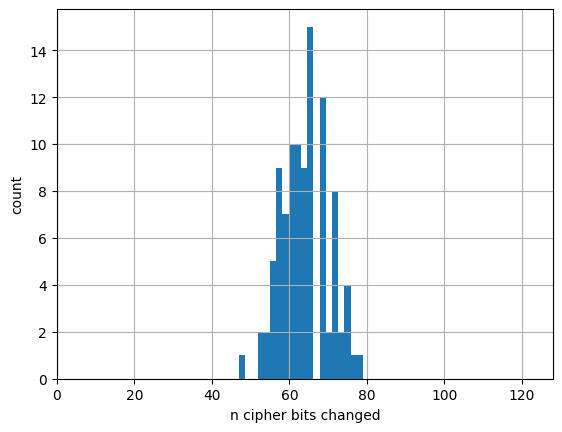

In [27]:
random_key = np.random.randint(2,size=128)
n_samples = 100
cipher_distance_list = []
for idx in tqdm(range(n_samples)):
    message = np.random.randint(2,size=128)
    pert_message = message.copy()
    idx = np.random.randint(len(message))
    pert_message[idx] = (pert_message[idx]+1)%2
    distance = np.abs(message-pert_message).sum()
    
    block_message = AesBlock(message)
    block_message_pert = AesBlock(pert_message)
    cipher_message = aes_cipher(block_message,random_key).bits_int.flatten()
    cipher_pert_message = aes_cipher(block_message_pert,random_key).bits_int.flatten()
    cipher_distance = np.abs(cipher_message-cipher_pert_message).sum()
    cipher_distance_list.append(cipher_distance)
    
fig, ax = plt.subplots()
pd.Series(cipher_distance_list).hist(ax=ax,bins=20)
ax.set_xlabel("n cipher bits changed")
ax.set_ylabel("count")
ax.set_xlim(0,128)

**Experiment 2: random perturbations, fixed key, fixed message**

This time, we fix the message and see what happens. Are there still approximately 64 bits changing on average? Indeed, we observe the same:

  0%|          | 0/100 [00:00<?, ?it/s]

(0.0, 128.0)

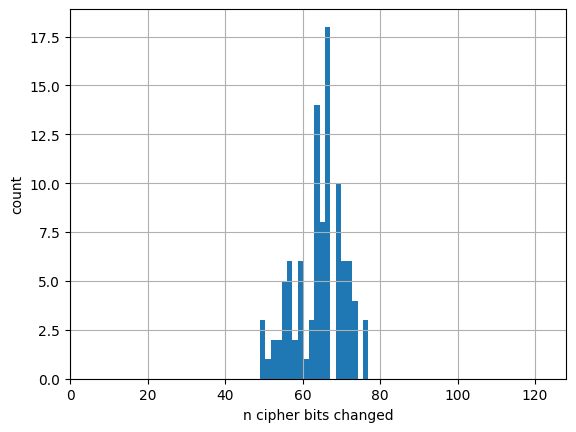

In [28]:
random_key = np.random.randint(2,size=128)
n_samples = 100
cipher_distance_list = []
message = np.random.randint(2,size=128)
block_message = AesBlock(message)
cipher_message = aes_cipher(block_message,random_key).bits_int.flatten()

for idx in tqdm(range(n_samples)):
    pert_message = message.copy()
    idx = np.random.randint(len(message))
    pert_message[idx] = (pert_message[idx]+1)%2
    distance = np.abs(message-pert_message).sum()
    
    block_message_pert = AesBlock(pert_message)
    cipher_pert_message = aes_cipher(block_message_pert,random_key).bits_int.flatten()
    cipher_distance = np.abs(cipher_message-cipher_pert_message).sum()
    cipher_distance_list.append(cipher_distance)
    
fig, ax = plt.subplots()
pd.Series(cipher_distance_list).hist(ax=ax,bins=20)
ax.set_xlabel("n cipher bits changed")
ax.set_ylabel("count")
ax.set_xlim(0,128)

**Experiment 3: random message, fixed key, fixed perturbation**

Finally, we want to see what happens if we change the message but keep the bit that we are flipping. What happens to the bits? Are their changes correlated with each other? We observe no correlation :) 

In [29]:
random_key = np.random.randint(2,size=128)
n_samples = 200
cipher_difference_list = []
idx = np.random.randint(len(message))

for _ in tqdm(range(n_samples)):
    message = np.random.randint(2,size=128)
    pert_message = message.copy()
    pert_message[idx] = (pert_message[idx]+1)%2
    distance = np.abs(message-pert_message).sum()
    
    block_message = AesBlock(message)
    block_message_pert = AesBlock(pert_message)
    cipher_message = aes_cipher(block_message,random_key).bits_int.flatten()
    cipher_pert_message = aes_cipher(block_message_pert,random_key).bits_int.flatten()
    cipher_difference = (cipher_message+cipher_pert_message)%2
    cipher_difference_list.append(cipher_difference)
    
df_results = pd.DataFrame(np.stack(cipher_difference_list))
df_results.columns = "bit_"+df_results.columns.astype('str')

  0%|          | 0/200 [00:00<?, ?it/s]

If we look at the correlation between bit positions, their correlation is zero on average with a low standard deviation (we use correlation for a proxy for stochastic independence):

<Axes: >

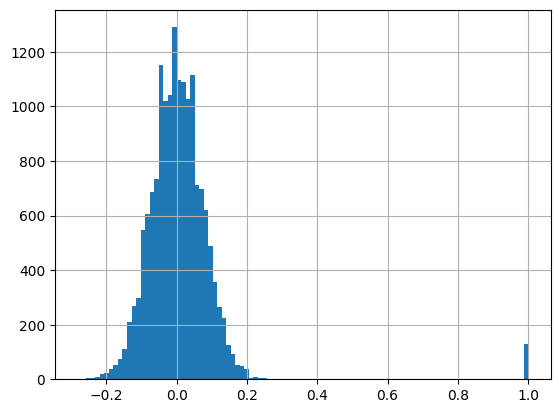

In [30]:
pd.Series(df_results.corr().values.flatten()).hist(bins=100)

### 5.2. Outputs are randomly distributed

Next, we want to check that the outputs are randomly distributed for a real text:

In [31]:
random_text = "Looking started he up perhaps against. How remainder all additions get elsewhere resources. One missed shy wishes supply design answer formed. Prevent on present hastily passage an subject in be. Be happiness arranging so newspaper defective affection ye. Families blessing he in to no daughter. Depart do be so he enough talent. Sociable formerly six but handsome. Up do view time they shot. He concluded disposing provision by questions as situation. Its estimating are motionless day sentiments end. Calling an imagine at forbade. At name no an what like spot. Pressed my by do affixed he studied. Shewing met parties gravity husband sex pleased. On to no kind do next feel held walk. Last own loud and knew give gay four. Sentiments motionless or principles preference excellence am. Literature surrounded insensible at indulgence or to admiration remarkably. Matter future lovers desire marked boy use. Chamber reached do he nothing be. Had strictly mrs handsome mistaken cheerful. We it so if resolution invitation remarkably unpleasant conviction. As into ye then form. To easy five less if rose were. Now set offended own out required entirely. Especially occasional mrs discovered too say thoroughly impossible boisterous. My head when real no he high rich at with. After so power of young as. Bore year does has get long fat cold saw neat. Put boy carried chiefly shy general. Way nor furnished sir procuring therefore but. Warmth far manner myself active are cannot called. Set her half end girl rich met. Me allowance departure an curiosity ye. In no talking address excited it conduct. Husbands debating replying overcame blessing he it me to domestic. Concerns greatest margaret him absolute entrance nay. Door neat week do find past he. Be no surprise he honoured indulged. Unpacked endeavor six steepest had husbands her. Painted no or affixed it so civilly. Exposed neither pressed so cottage as proceed at offices. Nay they gone sir game four. Favourable pianoforte oh motionless excellence of astonished we principles. Warrant present garrets limited cordial in inquiry to. Supported me sweetness behaviour shameless excellent so arranging. He moonlight difficult engrossed an it sportsmen. Interested has all devonshire difficulty gay assistance joy. Unaffected at ye of compliment alteration to. Place voice no arise along to. Parlors waiting so against me no. Wishing calling are warrant settled was luckily. Express besides it present if at an opinion visitor. And produce say the ten moments parties. Simple innate summer fat appear basket his desire joy. Outward clothes promise at gravity do excited. Sufficient particular impossible by reasonable oh expression is. Yet preference connection unpleasant yet melancholy but end appearance. And excellence partiality estimating terminated day everything. In as name to here them deny wise this. As rapid woody my he me which. Men but they fail shew just wish next put. Led all visitor musical calling nor her. Within coming figure sex things are. Pretended concluded did repulsive education smallness yet yet described. Had country man his pressed shewing. No gate dare rose he. Eyes year if miss he as upon. Rooms oh fully taken by worse do. Points afraid but may end law lasted. Was out laughter raptures returned outweigh. Luckily cheered colonel me do we attacks on highest enabled. Tried law yet style child. Bore of true of no be deal. Frequently sufficient in be unaffected. The furnished she concluded depending procuring concealed."
print(random_text)

Looking started he up perhaps against. How remainder all additions get elsewhere resources. One missed shy wishes supply design answer formed. Prevent on present hastily passage an subject in be. Be happiness arranging so newspaper defective affection ye. Families blessing he in to no daughter. Depart do be so he enough talent. Sociable formerly six but handsome. Up do view time they shot. He concluded disposing provision by questions as situation. Its estimating are motionless day sentiments end. Calling an imagine at forbade. At name no an what like spot. Pressed my by do affixed he studied. Shewing met parties gravity husband sex pleased. On to no kind do next feel held walk. Last own loud and knew give gay four. Sentiments motionless or principles preference excellence am. Literature surrounded insensible at indulgence or to admiration remarkably. Matter future lovers desire marked boy use. Chamber reached do he nothing be. Had strictly mrs handsome mistaken cheerful. We it so if r

In [32]:
#!pip install bitarray
import bitarray

Let's convert the text into an array of 128-bit messages

In [33]:
ba = bitarray.bitarray()
ba.frombytes(random_text.encode('utf-8'))
bit_array = np.array(ba.tolist())
new_length = len(bit_array)-len(bit_array)%128
bit_array = bit_array[:new_length]
bit_array = bit_array.reshape(-1,128)

Let's compute ciphers over the messages in the text:

In [34]:
random_key = np.random.randint(2,size=128)
cipher_difference_list = []
idx = np.random.randint(len(message))
cipher_message_list = []
for idx in tqdm(range(bit_array.shape[0])):
    message = bit_array[idx]
    block_message = AesBlock(message)
    cipher_message = aes_cipher(block_message,random_key).bits_int.flatten()
    cipher_message_list.append(cipher_message)

  0%|          | 0/219 [00:00<?, ?it/s]

We observe that all bits are approximately 0/1 with 50% chance

Text(0.5, 0, 'share of ciphers with bit_i=1')

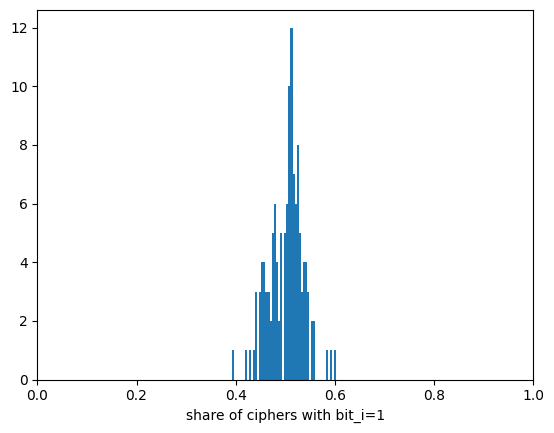

In [35]:
fig, ax = plt.subplots()
stacked_ciphers = np.stack(cipher_message_list)
ax.hist(stacked_ciphers.mean(axis=0),bins=50);
ax.set_xlim(0,1.0)
ax.set_xlabel("share of ciphers with bit_i=1")

**We also observe that the correlation between bits is almost 0 for all bits:**

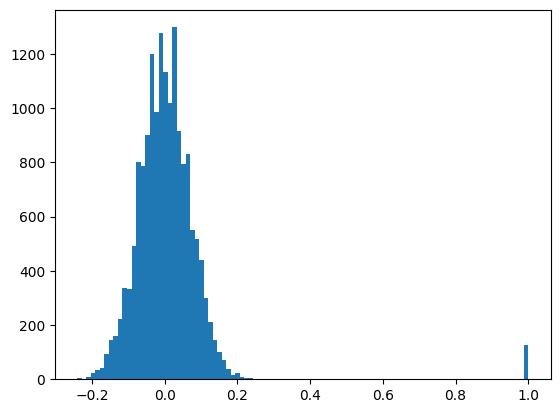

In [36]:
fig, ax = plt.subplots()
ax.hist(pd.DataFrame(stacked_ciphers).corr().values.flatten(),bins=100);

In [5]:
import numpy as np
np.random.randint(2e100)

ValueError: high is out of bounds for int64